In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import quad, trapezoid

In [3]:
def signal(t, A, tau, alpha):
    if 0 <= t <= tau:
        return A * t * np.exp(-alpha * t)
    else:
        return 0.0

In [4]:
def integrand_real(t, A, tau, alpha, omega):
    return signal(t, A, tau, alpha) * np.cos(omega * t)

In [5]:
def integrand_imag(t, A, tau, alpha, omega):
    return -signal(t, A, tau, alpha) * np.sin(omega * t)

In [6]:
def fourier_transform(omega, A, tau, alpha):
    real_part, _ = quad(integrand_real, 0, tau, args=(A, tau, alpha, omega,))
    imag_part, _ = quad(integrand_imag, 0, tau, args=(A, tau, alpha, omega,))
    return real_part + 1j * imag_part

In [7]:
def plot_amplitude_spectrum(omega, F_omegas, colors , taus):
    plt.figure(figsize=(12, 8))

    for ind in range(len(F_omegas)):
        plt.plot(omega, np.abs(F_omegas[ind]), label=f'Amplitude spectrum tau = {taus[ind]}', color=colors[ind])
    
    plt.ylabel('|F(ω)|')
    plt.grid(True)
    plt.legend()
    plt.show()

In [8]:
def plot_phase_spectrum(omega, F_omegas, colors, taus):
    plt.figure(figsize=(12, 8))

    for ind in range(len(F_omegas)):
        plt.plot(omega, np.angle(F_omegas[ind]), label=f'Amplitude spectrum tau = {taus[ind]}', color=colors[ind])
        
    plt.xlabel('ω')
    plt.ylabel('∠F(ω) [rad]')
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
A = 1.0
taus = [1.0, 2.0, 3.0]
alpha = 1.0
omega = np.linspace(-8, 8, 1000)
colors = ['r', 'g', 'b']

F_omegas = [np.array([fourier_transform(w, A, tau, alpha) for w in omega]) for tau in taus]

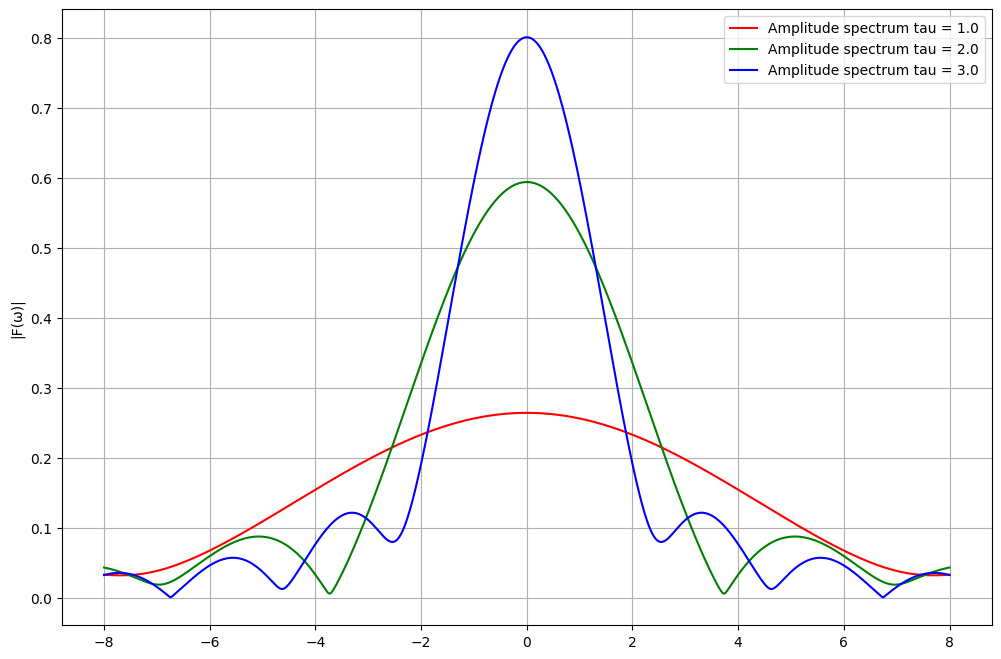

In [10]:
plot_amplitude_spectrum(omega=omega, F_omegas=F_omegas, colors=colors, taus=taus)

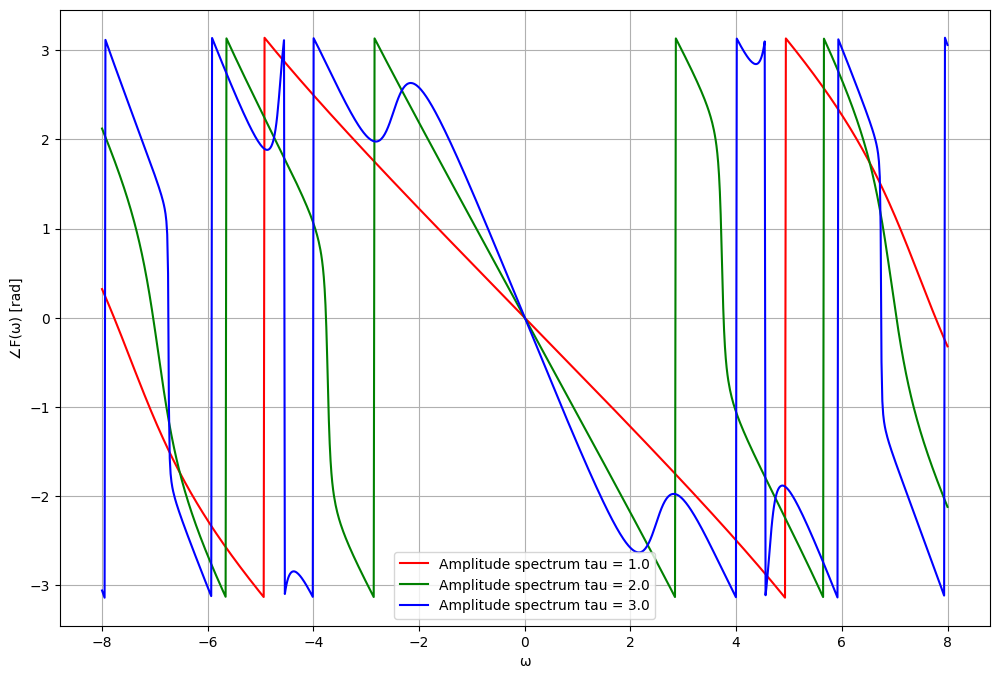

In [11]:
plot_phase_spectrum(omega=omega, F_omegas=F_omegas, colors=colors, taus=taus)

In [12]:
def inverse_fourier_transform(t, spectrum, omega_values, d_omega):
    integral = 0
    for i, omega in enumerate(omega_values):
        integral += spectrum[i] * np.exp(1j * omega * t) * d_omega
    return integral.real / (2 * np.pi)

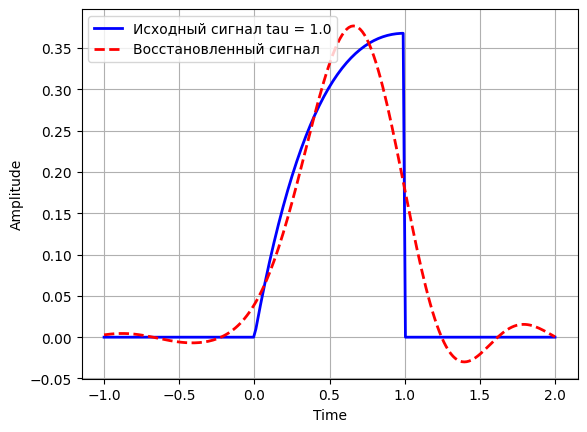

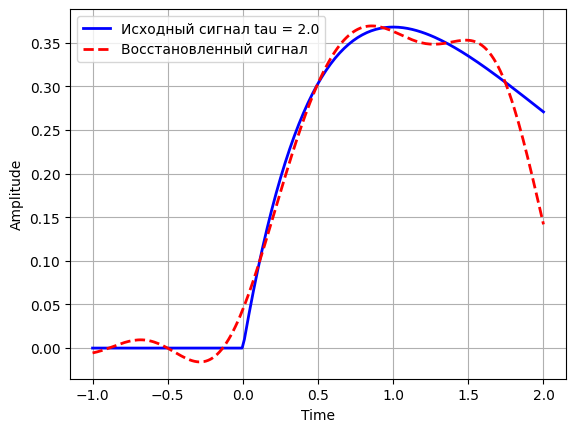

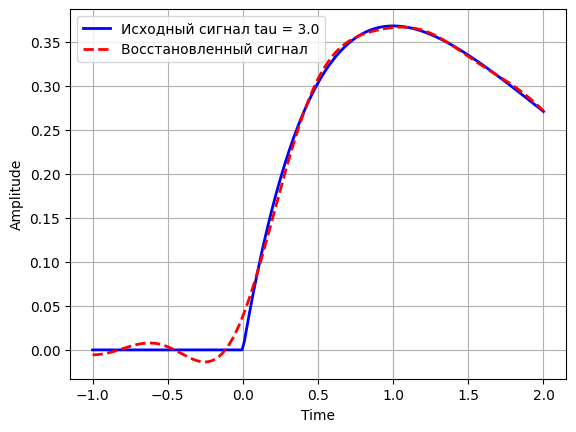

In [13]:
d_omega = omega[1] - omega[0]
t_values = np.linspace(-1, taus[0]+1, 200)

for ind in range(len(taus)):
    reconstructed = np.array([inverse_fourier_transform(t, F_omegas[ind], omega, d_omega) for t in t_values])
    original = np.array([signal(t, A, taus[ind], alpha) for t in t_values])

    plt.plot(t_values, original, 'b-', linewidth=2, label=f'Исходный сигнал tau = {taus[ind]}')
    plt.plot(t_values, reconstructed, 'r--', linewidth=2, label='Восстановленный сигнал')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
def calculate_energy(signal, t_values):
    squared_signal = signal**2
    energy = trapezoid(squared_signal, t_values)
    return energy

In [15]:
energy_original = calculate_energy(original, t_values)
energy_reconstructed = calculate_energy(reconstructed, t_values)
energy_original.item(), energy_reconstructed.item()

(0.19047282879900373, 0.19048797985870308)

In [16]:
def f1(t):
    return 1.0 if 0 <= t <= 2 else 0.0

def f2(t):
    return np.cos(t) if 0 < t < 2*np.pi else 0.0

In [17]:
def cross_correlation(tau):
    lower_bound = max(0, -tau)
    upper_bound = min(2, 2*np.pi - tau)

    if lower_bound >= upper_bound:
        return 0.0
    
    result, _ = quad(lambda t: f1(t) * f2(t + tau), lower_bound, upper_bound)
    return result

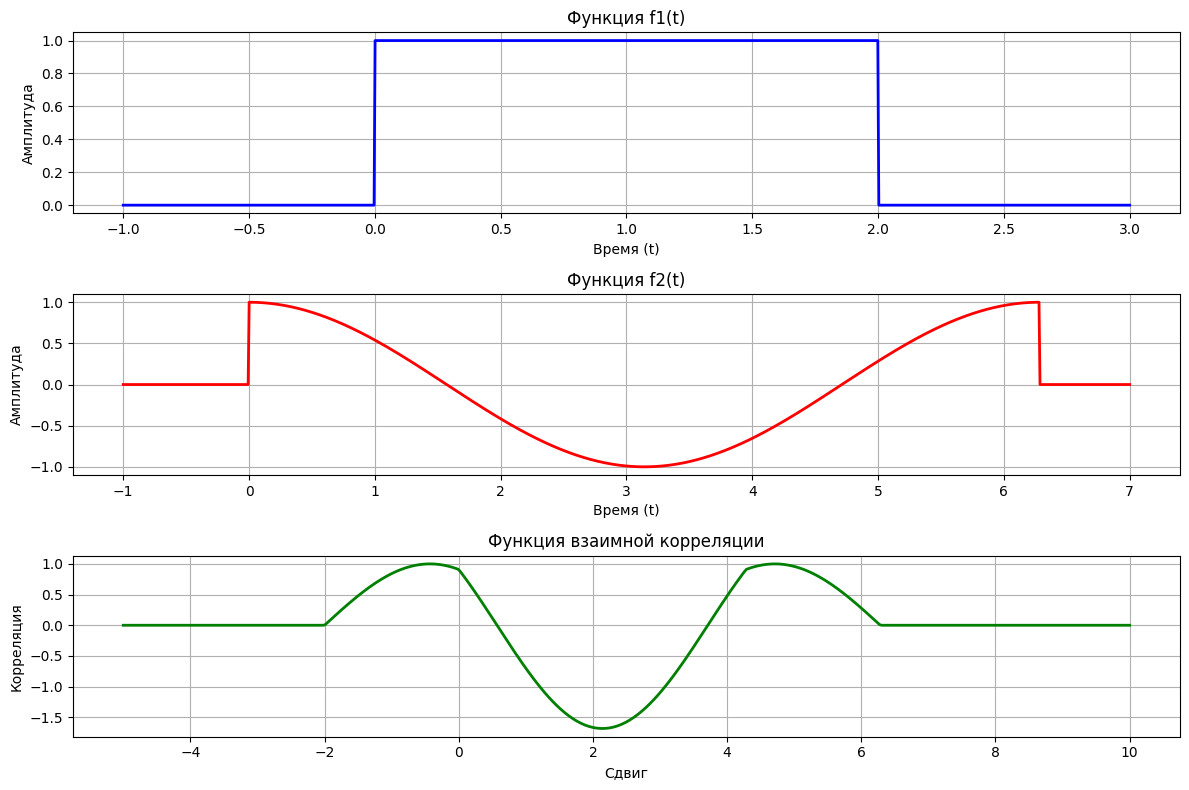

In [18]:
tau_values = np.linspace(-5, 10, 500)

correlation_values = [cross_correlation(tau) for tau in tau_values]

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
t_values1 = np.linspace(-1, 3, 1000)
f1_values = [f1(t) for t in t_values1]
plt.plot(t_values1, f1_values, 'b-', linewidth=2)
plt.title('Функция f1(t)')
plt.xlabel('Время (t)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(3, 1, 2)
t_values2 = np.linspace(-1, 7, 1000)
f2_values = [f2(t) for t in t_values2]
plt.plot(t_values2, f2_values, 'r-', linewidth=2)
plt.title('Функция f2(t)')
plt.xlabel('Время (t)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tau_values, correlation_values, 'g-', linewidth=2)
plt.title('Функция взаимной корреляции')
plt.xlabel('Сдвиг')
plt.ylabel('Корреляция')
plt.grid(True)

plt.tight_layout()
plt.show()

max_corr = max(correlation_values)
max_index = np.argmax(correlation_values)
max_tau = tau_values[max_index]


In [19]:
def signal(t, tau):
    return A / np.sqrt(1 + np.cosh(t/tau)**2)

In [20]:
def calculate_effective_duration(tau, t_max=1.0, num_points=10000):
    t_values = np.linspace(-t_max, t_max, num_points)    
    signal_values = signal(t_values, tau)    
    energy = np.trapezoid(signal_values**2, t_values)    
    t_center = np.trapezoid(t_values * signal_values**2, t_values) / energy
    t2_moment = np.trapezoid((t_values - t_center)**2 * signal_values**2, t_values) / energy
    effective_duration = np.sqrt(t2_moment)
    
    return effective_duration

In [21]:
A = 1.0
tau1 = 0.15
tau2 = 0.285

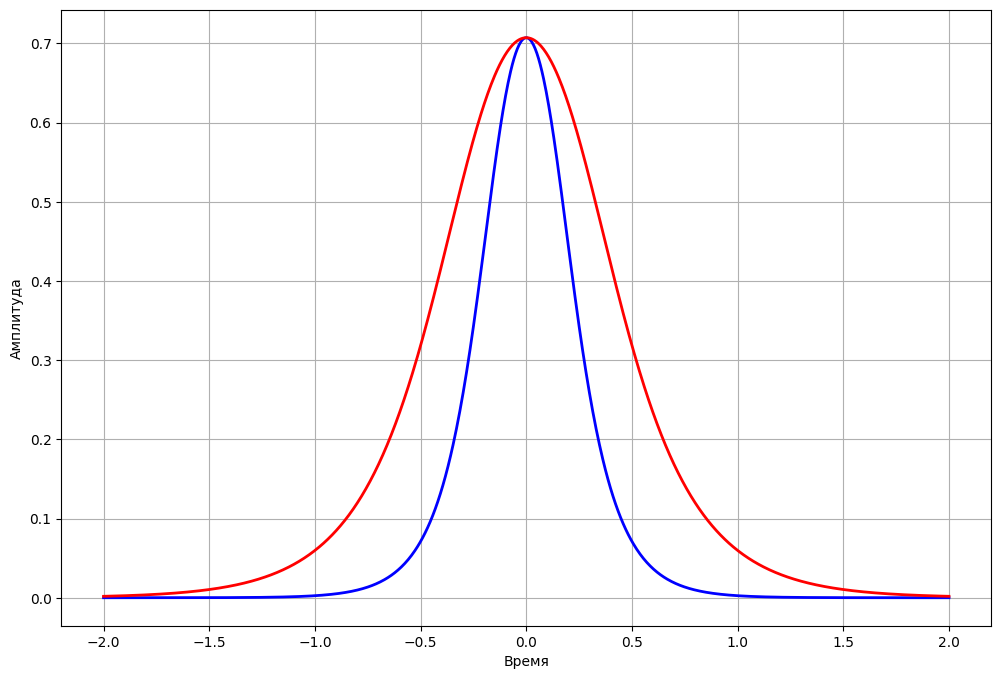

Для τ = 0.15: эффективная длительность = 0.155967
Для τ = 0.285: эффективная длительность = 0.290303


In [26]:
t_values = np.linspace(-2, 2, 1000)
signal_values1 = signal(t_values, tau1)
signal_values2 = signal(t_values, tau2)

plt.figure(figsize=(12, 8))
plt.plot(t_values, signal_values1, 'b-', linewidth=2, label=f"tau={tau1}")
plt.plot(t_values, signal_values2, 'r-', linewidth=2, label=f"tau={tau2}")
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.show()

eff_duration1 = calculate_effective_duration(tau1)
eff_duration2 = calculate_effective_duration(tau2)

print(f"Для τ = {tau1}: эффективная длительность = {eff_duration1:.6f}")
print(f"Для τ = {tau2}: эффективная длительность = {eff_duration2:.6f}")

In [28]:
def compute_spectrum(tau, t_max=5.0, n_points=2**14):
    t = np.linspace(-t_max, t_max, n_points)
    dt = t[1] - t[0]
    
    s = signal(t, tau)
    
    spectrum = fft(s)
    frequencies = fftfreq(n_points, dt)
    
    frequencies = fftshift(frequencies)
    spectrum = fftshift(spectrum)
    
    return frequencies, spectrum

In [29]:
freq1, spec1 = compute_spectrum(tau1)
freq2, spec2 = compute_spectrum(tau2)

amp_spec1 = np.abs(spec1)
amp_spec2 = np.abs(spec2)

norm_amp_spec1 = amp_spec1 / np.max(amp_spec1)
norm_amp_spec2 = amp_spec2 / np.max(amp_spec2)

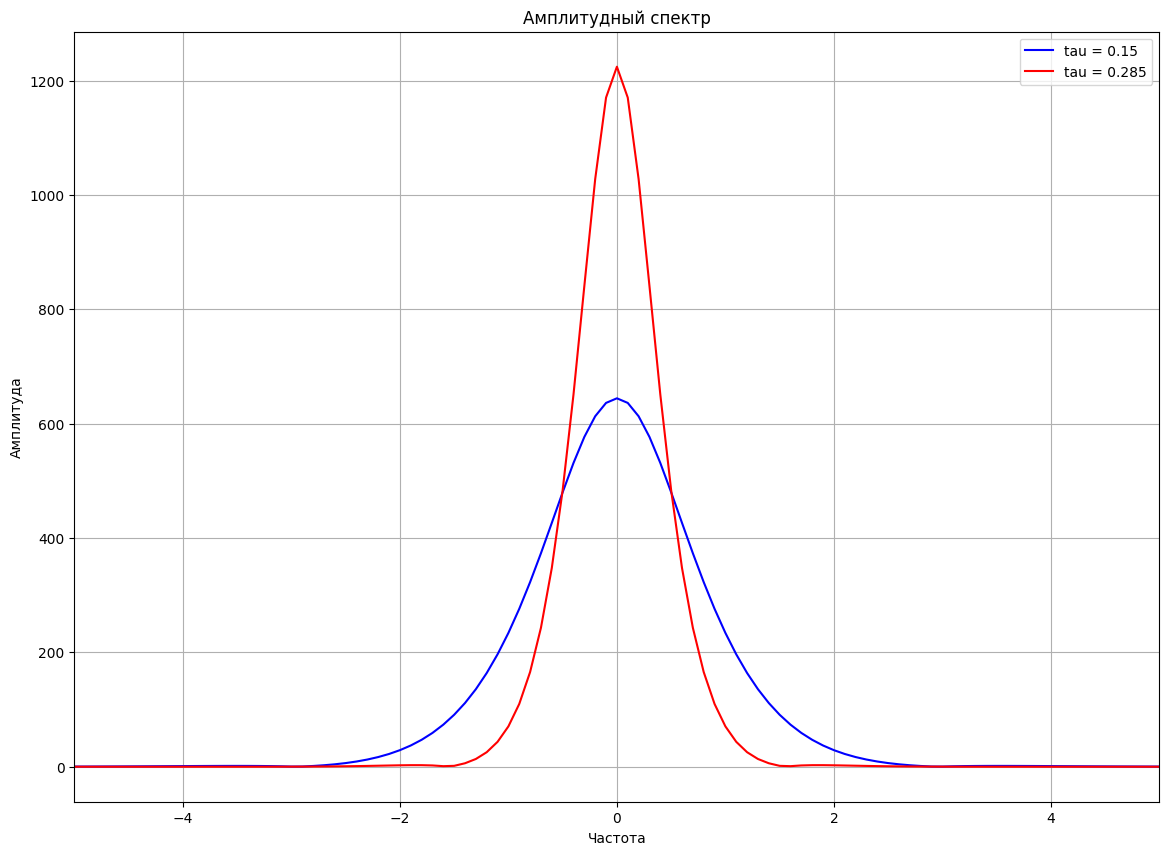

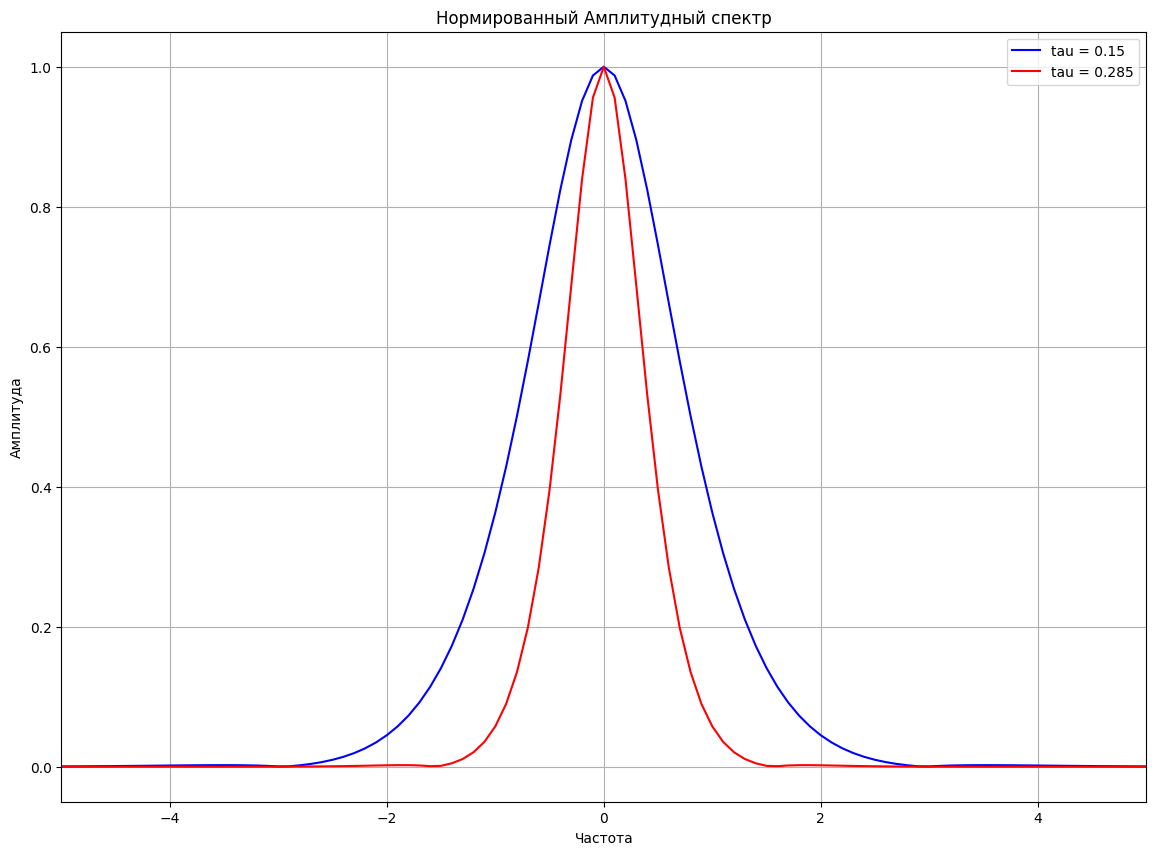

In [33]:
plt.figure(figsize=(14, 10))

plt.plot(freq1, amp_spec1, 'b-', linewidth=1.5, label=f"tau = {tau1}")
plt.plot(freq2, amp_spec2, 'r-', linewidth=1.5, label=f"tau = {tau2}")
plt.title(f'Амплитудный спектр')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()
plt.xlim(-5, 5)
plt.show()


plt.figure(figsize=(14, 10))

plt.plot(freq1, norm_amp_spec1, 'b-', linewidth=1.5, label=f"tau = {tau1}")
plt.plot(freq2, norm_amp_spec2, 'r-', linewidth=1.5, label=f"tau = {tau2}")
plt.title(f'Нормированный Амплитудный спектр')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()
plt.xlim(-5, 5)
plt.show()